# Project Overview

### Background:
The objective of the project is to find a good spot for a new sushi restaurant in Cologne, Germany. The resulting recommendation can provide future restaurant owners a first insight about the region's competition.



<table><tr><td><img src='Stuttgart-Innenstadt.jpg' width= "600"></td><td><img src='maki-sushi.jpg'width= "255"></td></tr></table>

### Approach / Methodology:
To achieve this, the DBSCAN Clustering Algorithm will be used. This algorithms can find the number of clusters depending on a spatial radius, making it a good fit for the given problem. \
These clusters will be used to create a map, that is visualizing hot spots, which likely are too competitive to create a new business. The solution will be to pick a spot, that is close to the center, but only part of a small cluster.

Additionally, there will also be an attractivity score calculated for each cluster respectively. This will be depending on the most popular leisure time spots inside or very close to the cluster compared to the number of restaurants.

At last, the clusters with the most likely chance of a successful market entrance will be compared in more detail, by using the ratings' and like counts' median and mean. If the number of restaurants in those clusters are exceeding 5, the 5 best restaurants in terms of rating and likes will be shown in a separate table as they will likely be the strongest competitors. If the number doesn't exceed 5, all will be shown in detail.

### Data:
The used data will be explorational data from the Foursquare DB, which is accessable without authentification. The core of the data are the geographical coordinates in order to create the map. However, also rating data of particular venues will be used.


In [2]:
import pandas as pd
import requests
from pandas.io.json import json_normalize

In [3]:
client_id = "LCWGCXXXXXXXXXXXXXXXXXXXXXXXXXXXRYV0"
client_secret = "H2HVPBKCXXXXXXXXXXXXXXXXXXXXXYBFMLZK5"

latitude = 50.938056
longitude = 6.956944
radius = 4000


In [4]:
def get_data(date, search_query): 
    '''
    This function returns a dataframe of the Foursquare Data depending on the given date and search term
    '''
    
    url = ('https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'
            .format(client_id, client_secret, latitude, longitude, date, search_query, radius, 500))


    results = requests.get(url).json()
    venues = results['response']['venues']

    df = pd.json_normalize(venues)

    return df

In [5]:
# Get sushi restaurant data
main_data = get_data(20200514, "sushi").loc[:,["id","name", "location.lat", "location.lng"]]


In [6]:
#Get leisure data by explore statement

url = ('https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&query=Fun&radius={}&limit={}'
            .format(client_id, client_secret, latitude, longitude, 20200514, radius, 500))

results = requests.get(url).json()
venues = results['response']


leisure = venues["groups"][0]["items"]

result = [entry["venue"] for entry in leisure]

result = [(entry["location"]["lat"], entry["location"]["lng"]) for entry in result]
leisure = pd.DataFrame(result, columns= ["lat", "lng"])
leisure

,lat,lng
0,50.938530,6.954084
1,50.937882,6.962241
2,50.940537,6.960486
3,50.938243,6.962875
4,50.937425,6.958523
...,...,...
95,50.922367,6.965660
96,50.948068,6.908591
97,50.916994,6.928838
98,50.961884,6.978495


In [7]:
"Number of Sushi Restaurants in Cologne: {}".format(main_data.shape[0])

'Number of Sushi Restaurants in Cologne: 48'

### Clustering

In [8]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [9]:
coords = main_data.loc[:,["location.lat", "location.lng"]]
coords = StandardScaler().fit_transform(coords)

db_cluster = DBSCAN(eps = 0.35, min_samples = 3).fit(coords)

labels = db_cluster.labels_
label_num = len(np.unique(labels))
main_data["label"] = labels


In [10]:
label_counter = {}

for lat, lng in leisure.values:
    sushi_coords = main_data.loc[:,["location.lat", "location.lng"]]
    sushi_coords.iloc[:,0] = sushi_coords.iloc[:,0] - lat
    sushi_coords.iloc[:,1] = sushi_coords.iloc[:,1] - lng
    sushi_coords = np.abs(np.sum(sushi_coords, axis = 1))
    closest = sushi_coords.argmin()
    label_counter[labels[closest]] = label_counter.get(labels[closest], 0) + 1

label_counter = {k: label_counter[k] for k in sorted(label_counter)}
label_counter

{-1: 42, 0: 32, 1: 23, 2: 3}

### Visualizing 

In [11]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import folium
import operator

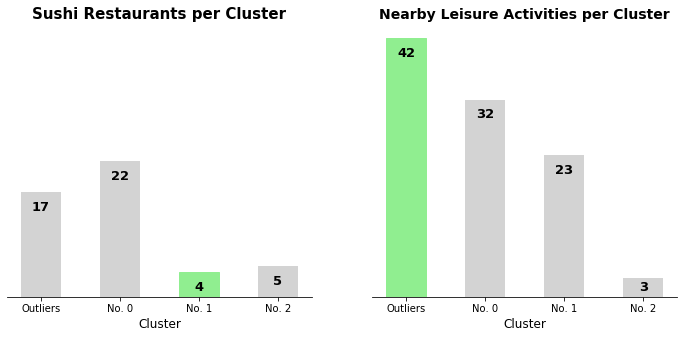

In [12]:
labels_unique =np.unique(labels, return_counts=True)
graph_labels = np.unique(labels)[1:].tolist()
graph_labels =["No. {}".format(k) for k in graph_labels]
graph_labels.insert(0,"Outliers")

fig = plt.figure(figsize=(12,5))
sushi_bar = fig.add_subplot(1,2,1)
leisure_bar = fig.add_subplot(1,2,2, sharex = sushi_bar, sharey = sushi_bar)

bars1 = sushi_bar.bar(labels_unique[0], labels_unique[1], width = 0.5, color = "lightgrey")
sushi_bar.set_xticks(np.unique(labels))
sushi_bar.set_xticklabels(graph_labels)
sushi_bar.tick_params(axis = "y",
                     labelleft = None,
                     left = None)

sushi_bar.set_title("Sushi Restaurants per Cluster", fontsize=15,fontweight="bold")
sushi_bar.set_xlabel("Cluster", fontsize=12)
bars1[np.argmin(labels_unique[1])].set_color("lightgreen")

for bar in bars1:
    sushi_bar.text(bar.get_x() + bar.get_width()/2, bar.get_height()-3,
                  int(bar.get_height()), ha="center", color="black", fontsize=13, fontweight="bold")


bars2 = leisure_bar.bar(label_counter.keys(), label_counter.values(), width = 0.5, color ="lightgrey")
leisure_bar.tick_params(axis = "y",
                     labelleft = None,
                     left = None)

leisure_bar.set_title("Nearby Leisure Activities per Cluster", fontsize=14, fontweight="bold")
leisure_bar.set_xlabel("Cluster", fontsize=12)
bars2[np.argmax(label_counter.values())].set_color("lightgreen")

for bar in bars2:
    if bar.get_height() > 3:
        height = bar.get_height()-3
    else:
        height = bar.get_height()-2
    leisure_bar.text(bar.get_x() + bar.get_width()/2, height,
                  int(bar.get_height()), ha="center", color="black", fontsize=13, fontweight="bold")

for ax in fig.get_axes():
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.show()

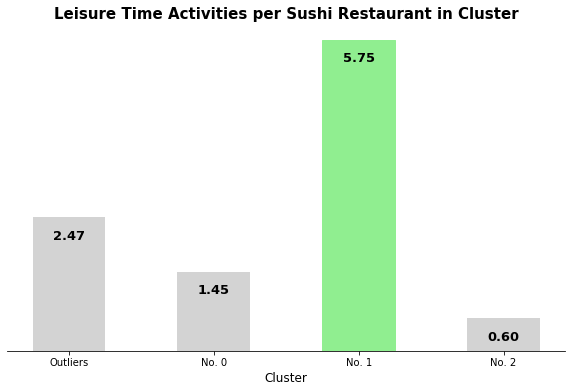

In [13]:
attractivity_score = [attractions/restaurants for restaurants, attractions in zip(list(labels_unique[1]), list(label_counter.values()))]

plt.figure(figsize=(10,6))
bars3 = plt.bar(label_counter.keys(), attractivity_score, width = 0.5, color = "lightgrey")

plt.xticks(np.unique(labels), graph_labels)
plt.tick_params(axis = "y",
                labelleft = None,
                left = None)

for bar in bars3:
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height()-0.4,
                  "{:.2f}".format(float(bar.get_height())), ha="center", color="black", fontsize=13, fontweight="bold")

bars3[np.argmax(attractivity_score)].set_color("lightgreen")    
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.title("Leisure Time Activities per Sushi Restaurant in Cluster", fontsize=15, fontweight="bold")
plt.xlabel("Cluster", fontsize=12)

plt.show();



In [20]:
map_result = folium.Map(location=[latitude, longitude], zoom_start=13)


# set color scheme for the clusters
x = np.arange(label_num)
ys = [i + x + (i*x)**2 for i in range(label_num)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map

for lat, lon, poi, cluster in zip(main_data['location.lat'], main_data['location.lng'], main_data['name'], labels):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    if cluster != -1:
        c = rainbow[cluster-1]
    else:
        c = "black"
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=c,
        fill=True,
        fill_color=c,
        fill_opacity=0.7).add_to(map_result)
       
map_result

### What can we see?

Cluster 0 clearly is cologne city. It is attracting many people from nearby, but also seems to be very contested. This doesn't seem like a good spot for a new restaurant.

It looks like cluster 1 and cluster 2 are spots, which aren't too competitive. However, cluster 2 likely won't attract as many customers from nearby leisure spots.
Let's still have closer look at the possible future competitors in both clusters.

In [15]:
def get_ratings(ven_id, date): 
    '''
    This function returns a dataframe of the Foursquare Data depending on the given venue id and date
    '''
    
    url = ('https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'
            .format(ven_id, client_id, client_secret, date))


    results = requests.get(url).json()
    venue = results['response']["venue"]

    
    df = pd.json_normalize(venue)
    try:
        rating, likes = df["rating"].values[0], df["likes.count"].values[0]
    except KeyError:
        likes = df["likes.count"].values[0]
        return (np.nan, likes)
    
    
    return (rating,likes)


In [16]:
backup = main_data.copy()
backup = backup[backup["label"].isin([1,2])]
competition_ratings = backup["id"].apply(get_ratings,args=(20200515,))

In [17]:
competition = backup.copy()
competition_r = [x[0] for x in competition_ratings]
competition_l = [x[1] for x in competition_ratings]

competition.loc[:,"rating"] = competition_r
competition.loc[:,"likes"] = competition_l

competition = competition.loc[:,["name", "rating", "likes","label"]]
competition = competition.set_index("name")
cluster1 = competition[competition["label"] == 1].drop("label", axis = 1)
cluster2 = competition[competition["label"] == 2].drop("label", axis = 1)

In [18]:
print("Cluster 1")
cluster1.describe()

Cluster 1


,rating,likes
count,3.000000,4.000000
mean,6.733333,6.250000
std,1.504438,6.020797
min,5.000000,1.000000
25%,6.250000,1.750000
50%,7.500000,5.000000
75%,7.600000,9.500000
max,7.700000,14.000000


In [19]:
print("Cluster 2")
cluster2.describe()

Cluster 2


,rating,likes
count,4.000000,5.000000
mean,8.025000,15.800000
std,0.298608,9.284396
min,7.600000,6.000000
25%,7.975000,12.000000
50%,8.100000,14.000000
75%,8.150000,16.000000
max,8.300000,31.000000


| Cluster 1                          |   rating |   likes |
|:------------------------------|---------:|--------:|
| MakiMaki Sushi Green          |      7.5 |      14 |
| Sushi Mii Bar Restaurant Köln |      5   |       2 |
| Sushi Make                    |    No data   |       1 |
| Sushi deLux                   |      7.7 |       8 |

| Cluster 2        |   rating |   likes |
|:------------|---------:|--------:|
| Sushi Teria |      7.6 |      12 |
| Sushi Ninja |      8.1 |      31 |
| MJ Sushi    |      8.3 |      14 |
| Sweet Sushi |      8.1 |      16 |
| Akémi       |    No data   |       6 |


### How do the restaurants in the clusters perform?

It becomes apparant, that the restaurants in Cluster 2 perform far better in both, likes and rating. \
The restaurants in cluster 1 seem to be the by far weaker competition.

# Results

The analysis overall results in the following main findings:

---

- There currently are 48 sushi restaurants located in cologne (radius of 4km from city center).

---

- The clustering algorithm found, that there are 3 clusters accompanied by many spread out outliers at the city's outskirts. While cluster No. 0 is the by far biggest cluster with 22 restaurants located in the city's center, cluster No. 1 and No. 2 are much smaller with 4 and 5 restaurants respectively.

---

- As the outliers are pretty scattered, they are attracting the most possible customers from leisure spots. Followed with 32 and 23 locations in cluster No. 0 and No. 1, these also hold a solid share. However, cluster No. 2 is containing almost no attractive locations.

---

- Proportioned by the number of restaurants in the cluster, the leisure location rate of cluster No. 1 is by far the best with 5.75. Cluster 0 and 1 can hardly compete with a rate of 1.45/0.60

--- 

- Comparing the restaurants in cluster No. 1 and No. 2, cluster 2's restaurants perform much better in both, likes and rating.

# Recommendation

Based on the analysed data, cluster 1 seems to be the most attractive cluster for opening a new sushi restaurants. There aren't many future competitors in the region, while a lot of popular places are near, which likely will be attracting possible customers. \ 
Additionally, the few competitor restaurants in cluster 1 aren't performing very well in terms of user ranking and user likes. The strongest competitors seem to be "MakiMaki Shushi Green" and "Sushi deLuxe". The others two restaurants have got poor ratings and/or likes.

If confrontation is not an option, it might be considered to settle into a outlier spot near the city's center. This still might be a risky decision though, as the outlier spots near the center are close to the hard-fought cluster No. 0

# Conclusion

The objective of the analysis was to find a good spot for a new sushi restaurant in Cologne. Based on the given data from the Foursquare DB, it was possible to provide a recommendation. The recommendation is to consider the region "Köln South", which was cluster No. 1 in the analysis.
It is important to note that one used criteria for this recommendation was the density of attractive leisure places nearby. Likely better results could've been archieved by analysing motion data. As this data isn't publicly available in sufficient quality, this hasn't been done.